In [ ]:
!pip install scienceplots

In [ ]:
!git clone https://github.com/nmudur/HartreeFock_GPT.git

fatal: destination path 'HartreeFock_GPT' already exists and is not an empty directory.


In [ ]:
!pip install openai==0.28
!pip install tiktoken
!pip install python-dotenv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re
import openai
import pandas as pd
import numpy as np
import json

In [ ]:
from HartreeFock_GPT import utils, annotation_utils, lm_utils

In [ ]:
ARXIV_IDS = annotation_utils.ANNOTATED_PAPERS

In [ ]:
len(ARXIV_IDS)

14

In [ ]:
DATA_DIR = '/content/drive/MyDrive/HF annotation/datasets/execution_updated/'

In [ ]:
ZS_DIR = '/content/drive/MyDrive/HF annotation/datasets/execution_updated/ZeroShot/'

# Redo Scoring Analysis for Zero-Shot

In [ ]:
execution_df = pd.read_csv(os.path.join(ZS_DIR, 'lm_scores_zeroshot_twolevel_final.csv'), dtype={'paper': str})

In [ ]:
execution_df.loc[43]

paper                                                                    1812.04213
task                              Construct Kinetic Hamiltonian (continuum versi...
execution_prompt                  You will be instructed to describe the kinetic...
lm_execution_completion           The kinetic term of the Hamiltonian in the fla...
score_prompt                      PROBLEM: You will be instructed to describe th...
lm_score                                                                          1
gt_score_in_paper                                                                 1
gt_score_prompt_quality                                                           1
gt_score_follow_instructions                                                      2
gt_score_physics_logic                                                            2
gt_score_math_derivation                                                          2
gt_score_final_answer_accuracy                                              

In [ ]:
execution_df.loc[150]

paper                                                                    2308.07488
task                              Construct Potential Hamiltonian (continuum ver...
execution_prompt                  You will be instructed to describe the potenti...
lm_execution_completion           The potential Hamiltonian $H_P$ in the real sp...
score_prompt                      PROBLEM: You will be instructed to describe th...
lm_score                                                                          1
gt_score_in_paper                                                                 1
gt_score_prompt_quality                                                           2
gt_score_follow_instructions                                                      1
gt_score_physics_logic                                                            1
gt_score_math_derivation                                                          2
gt_score_final_answer_accuracy                                              

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
gpt_scores = execution_df['lm_score'].to_numpy()
gpt_scores = np.array([int(s) for s in gpt_scores])
ground_truth_faa_scores = execution_df['gt_score_final_answer_accuracy'].to_numpy()
ground_truth_faa_scores = np.array([int(s)  if s != 'NA' else np.nan for s in ground_truth_faa_scores])

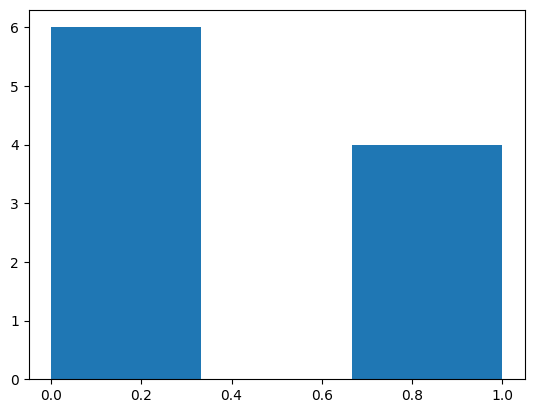

In [ ]:
true_score = 0
mask = (ground_truth_faa_scores==true_score)
plt.figure()
plt.hist(gpt_scores[mask], bins=3)
plt.show()

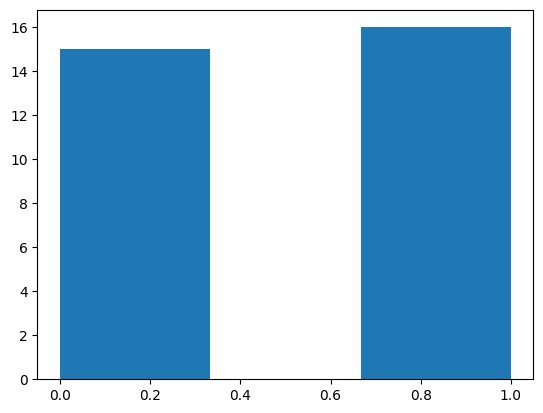

In [ ]:
true_score = 1
mask = (ground_truth_faa_scores==true_score)
plt.figure()
plt.hist(gpt_scores[mask], bins=3)
plt.show()

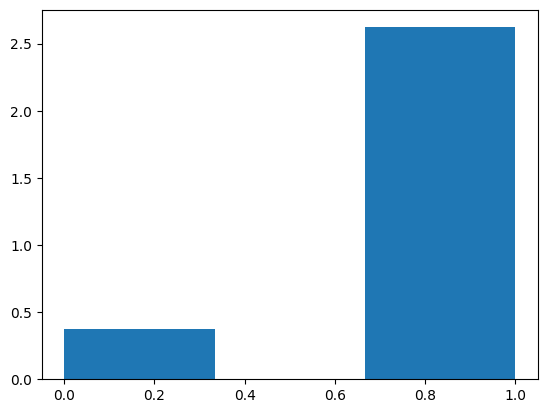

In [ ]:
true_score = 2
mask = (ground_truth_faa_scores==true_score)
plt.figure()
plt.hist(gpt_scores[mask], bins=3, density=True)
plt.show()

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix

In [ ]:
nanmask = ~np.isnan(ground_truth_faa_scores)

In [ ]:
nanmask.sum(), len(nanmask)

(160, 160)

In [ ]:
ground_truth_binary = (ground_truth_faa_scores==2).astype(int)

In [ ]:
conf_matrix = confusion_matrix(ground_truth_binary, gpt_scores)

In [ ]:
conf_matrix

array([[ 21,  20],
       [ 15, 104]])

In [ ]:
conf_matrix.sum(axis=1).sum(), conf_matrix.sum(axis=0).sum()

(160, 160)

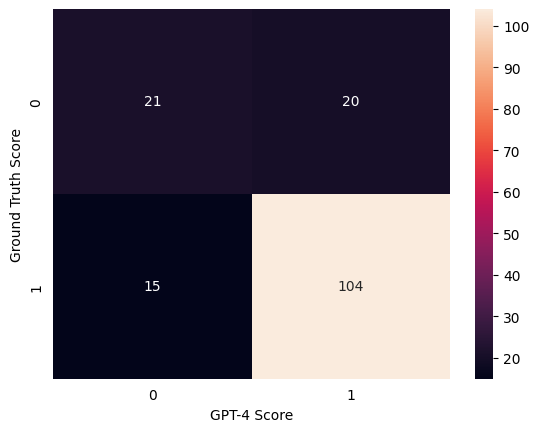

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
ax=sns.heatmap(conf_matrix, annot=True, fmt="d")
ax.grid(False)
ax.set_xlabel('GPT-4 Score')
ax.set_ylabel('Ground Truth Score')
ax.xaxis.set_ticklabels([0, 1])
ax.xaxis.set_ticklabels([0, 1])
ax.tick_params(left=False, bottom=False)
# plt.savefig(os.path.join(ZS_DIR, 'confusion_matrix_binary_final.png'))
plt.show()

In [ ]:
sklearn.metrics.accuracy_score(ground_truth_binary, gpt_scores)

0.78125

In [ ]:
sklearn.metrics.balanced_accuracy_score(ground_truth_binary, gpt_scores)

0.6930723508915761

In [ ]:
def get_all_scoring_metrics(ground_truth_binary, gpt_scores_test):
  metrics = {}
  metrics['accuracy_unbalanced'] = sklearn.metrics.accuracy_score(ground_truth_binary, gpt_scores_test)
  metrics['accuracy_balanced'] = sklearn.metrics.balanced_accuracy_score(ground_truth_binary, gpt_scores_test)
  out = sklearn.metrics.precision_recall_fscore_support(ground_truth_binary, gpt_scores_test, labels=[0, 1]) # Note zero_divison is 0.0 default here
  metrics['precision_classwise'] = out[0]
  metrics['recall_classwise'] = out[1]
  metrics['f1_classwise'] = out[2]
  metrics['support_classwise'] = out[3]
  metrics['Total Problems'] = len(ground_truth_binary)
  return metrics

def render_metrics(metrics):
  print('Metrics')
  for k, v in metrics.items():
    print(f'{k}: {v}')
  return

In [ ]:
# GPT-4 Scores
test_scores = np.ones(len(ground_truth_binary))
print('GPT-4 Score')
metrics = get_all_scoring_metrics(ground_truth_binary, gpt_scores)
render_metrics(metrics)

GPT-4 Score
Metrics
accuracy_unbalanced: 0.78125
accuracy_balanced: 0.6930723508915761
precision_classwise: [0.58333333 0.83870968]
recall_classwise: [0.51219512 0.87394958]
f1_classwise: [0.54545455 0.85596708]
support_classwise: [ 41 119]
Total Problems: 160


In [ ]:
# random predictor
rng = np.random.default_rng(seed=23)
test_scores = rng.choice(2, size=len(ground_truth_binary))
print('Randomly predicts 0|1')
metrics = get_all_scoring_metrics(ground_truth_binary, test_scores)
render_metrics(metrics)

Randomly predicts 0|1
Metrics
accuracy_unbalanced: 0.45625
accuracy_balanced: 0.4825783972125436
precision_classwise: [0.24444444 0.72857143]
recall_classwise: [0.53658537 0.42857143]
f1_classwise: [0.33587786 0.53968254]
support_classwise: [ 41 119]
Total Problems: 160


In [ ]:
# Always predicts 1
test_scores = np.ones(len(ground_truth_binary))
print('Always predicts 1')
metrics = get_all_scoring_metrics(ground_truth_binary, test_scores)
render_metrics(metrics)

Always predicts 1
Metrics
accuracy_unbalanced: 0.74375
accuracy_balanced: 0.5
precision_classwise: [0.      0.74375]
recall_classwise: [0. 1.]
f1_classwise: [0.         0.85304659]
support_classwise: [ 41 119]
Total Problems: 160


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Plot for 158 problems for Zero-Shot (Excluding the examples used in the Few-Shot experiment)

In [ ]:
execution_df = pd.read_csv(os.path.join(ZS_DIR, 'lm_scores_zeroshot_twolevel_final.csv'), dtype={'paper': str})

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
gpt_scores = execution_df['lm_score'].to_numpy()
gpt_scores = np.array([int(s) for s in gpt_scores])
ground_truth_faa_scores = execution_df['gt_score_final_answer_accuracy'].to_numpy()
ground_truth_faa_scores = np.array([int(s)  if s != 'NA' else np.nan for s in ground_truth_faa_scores])

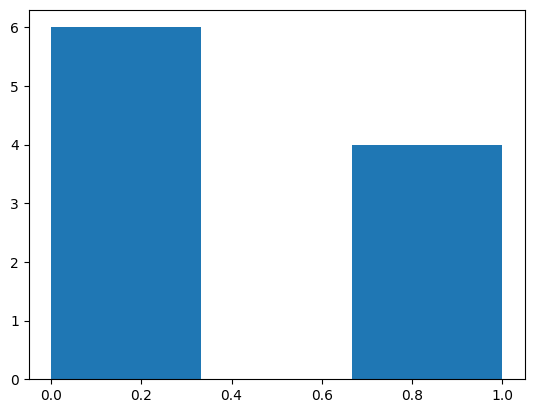

In [ ]:
true_score = 0
mask = (ground_truth_faa_scores==true_score)
plt.figure()
plt.hist(gpt_scores[mask], bins=3)
plt.show()

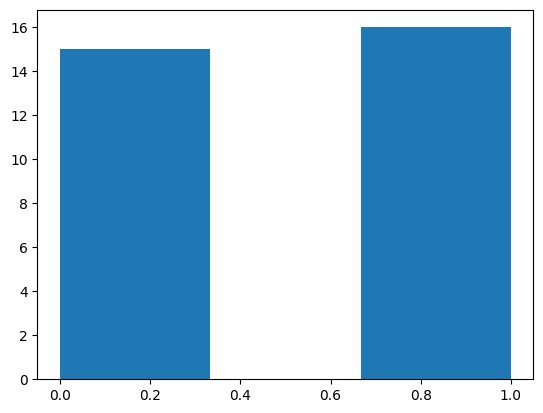

In [ ]:
true_score = 1
mask = (ground_truth_faa_scores==true_score)
plt.figure()
plt.hist(gpt_scores[mask], bins=3)
plt.show()

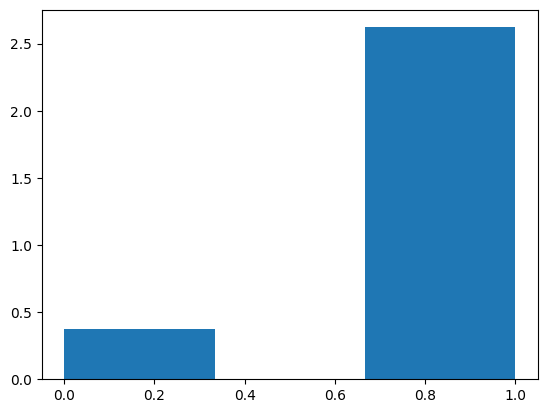

In [ ]:
true_score = 2
mask = (ground_truth_faa_scores==true_score)
plt.figure()
plt.hist(gpt_scores[mask], bins=3, density=True)
plt.show()

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix

In [ ]:
egmask = ~np.isnan(ground_truth_faa_scores)

In [ ]:
egmask.sum(), len(egmask)

(160, 160)

In [ ]:
egmask[[150, 137]] = False

In [ ]:
egmask.sum()

158

In [ ]:
ground_truth_binary = (ground_truth_faa_scores[egmask]==2).astype(int)

In [ ]:
ground_truth_faa_scores[:10], ground_truth_binary[:10]

(array([0, 2, 1, 0, 2, 2, 2, 0, 1, 2]), array([0, 1, 0, 0, 1, 1, 1, 0, 0, 1]))

In [ ]:
gpt_scores_test = gpt_scores[egmask]

In [ ]:
len(gpt_scores_test), len(ground_truth_binary)

(158, 158)

In [ ]:
conf_matrix = confusion_matrix(ground_truth_binary, gpt_scores_test)

In [ ]:
conf_matrix

array([[ 21,  19],
       [ 15, 103]])

In [ ]:
conf_matrix.sum(axis=1).sum(), conf_matrix.sum(axis=0).sum()

(158, 158)

In [ ]:
ZS_DIR

'/content/drive/MyDrive/HF annotation/datasets/execution_updated/ZeroShot/'

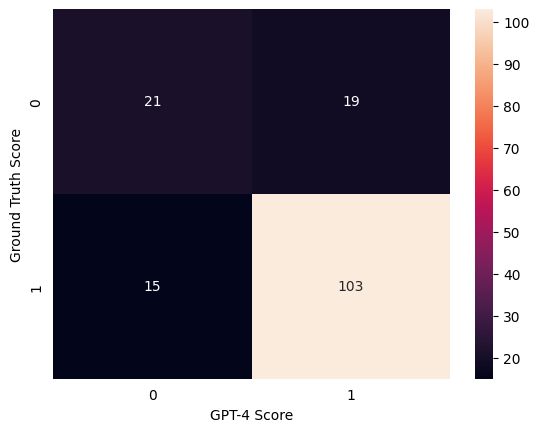

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
ax=sns.heatmap(conf_matrix, annot=True, fmt="d")
ax.grid(False)
ax.set_xlabel('GPT-4 Score')
ax.set_ylabel('Ground Truth Score')
ax.xaxis.set_ticklabels([0, 1])
ax.xaxis.set_ticklabels([0, 1])
ax.tick_params(left=False, bottom=False)
plt.savefig(os.path.join(ZS_DIR, 'confusion_matrix_binary_noexample158_final.png'))
plt.show()

In [ ]:
(gpt_scores_test==1).sum(), (ground_truth_binary==1).sum()

(122, 118)

In [ ]:
sklearn.metrics.accuracy_score(ground_truth_binary, gpt_scores_test)

0.7848101265822784

In [ ]:
(ground_truth_binary==1).sum()/len(ground_truth_binary) #the score if the model had blindly predicted 2 for all blanks

0.7468354430379747

Giving all GT scores (classes) the same 'weight'

In [ ]:
sklearn.metrics.balanced_accuracy_score(ground_truth_binary, gpt_scores_test)

0.6989406779661017

In [ ]:
# GPT-4 Scores
test_scores = np.ones(len(ground_truth_binary))
print('GPT-4 Score')
metrics = get_all_scoring_metrics(ground_truth_binary, gpt_scores_test)
render_metrics(metrics)

GPT-4 Score
Metrics
accuracy_unbalanced: 0.7848101265822784
accuracy_balanced: 0.6989406779661017
precision_classwise: [0.58333333 0.8442623 ]
recall_classwise: [0.525      0.87288136]
f1_classwise: [0.55263158 0.85833333]
support_classwise: [ 40 118]
Total Problems: 158


In [ ]:
# random predictor
rng = np.random.default_rng(seed=23)
test_scores = rng.choice(2, size=len(ground_truth_binary))
print('Randomly predicts 0|1')
metrics = get_all_scoring_metrics(ground_truth_binary, test_scores)
render_metrics(metrics)

Randomly predicts 0|1
Metrics
accuracy_unbalanced: 0.4620253164556962
accuracy_balanced: 0.49110169491525424
precision_classwise: [0.24719101 0.73913043]
recall_classwise: [0.55       0.43220339]
f1_classwise: [0.34108527 0.54545455]
support_classwise: [ 40 118]
Total Problems: 158


In [ ]:
# Always predicts 1
test_scores = np.ones(len(ground_truth_binary))
print('Always predicts 1')
metrics = get_all_scoring_metrics(ground_truth_binary, test_scores)
render_metrics(metrics)

Always predicts 1
Metrics
accuracy_unbalanced: 0.7468354430379747
accuracy_balanced: 0.5
precision_classwise: [0.         0.74683544]
recall_classwise: [0. 1.]
f1_classwise: [0.         0.85507246]
support_classwise: [ 40 118]
Total Problems: 158


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Task Wise Scoring Analysis

In [ ]:
execution_df = pd.read_csv(os.path.join(ZS_DIR, 'lm_scores_zeroshot_twolevel_final.csv'), dtype={'paper': str})

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
gpt_scores = execution_df['lm_score'].to_numpy()
gpt_scores = np.array([int(s) for s in gpt_scores])
ground_truth_faa_scores = execution_df['gt_score_final_answer_accuracy'].to_numpy()
ground_truth_faa_scores = np.array([int(s)  if s != 'NA' else np.nan for s in ground_truth_faa_scores])

In [ ]:
ground_truth_binary = (ground_truth_faa_scores==2).astype(int)
scoring_accuracy = np.equal(gpt_scores, ground_truth_binary).astype(int)

In [ ]:
execution_df['binary_scoring_accuracy'] = scoring_accuracy

In [ ]:
result = execution_df.groupby(['task'], as_index=False).agg({'binary_scoring_accuracy':['mean','sem']})

In [ ]:
result

task binary_scoring_accuracy  \
                                                                         mean   
0                   Combine the Hartree and Fock term                0.500000   
1   Construct Kinetic Hamiltonian (continuum versi...                0.500000   
2   Construct Kinetic Hamiltonian (continuum versi...                0.600000   
3     Construct Kinetic Hamiltonian (lattice version)                1.000000   
4   Construct Potential Hamiltonian (continuum ver...                0.750000   
5   Construct interaction Hamiltonian (momentum sp...                0.714286   
6   Construct interaction Hamiltonian (real space,...                0.857143   
7   Convert from single-particle to second-quantiz...                0.750000   
8   Convert from single-particle to second-quantiz...                0.500000   
9   Convert interacting Hamiltonian in real space ...                1.000000   
10  Convert noninteracting Hamiltonian in real spa...                0.500000   
11  Convert noninteracting Hamiltonian in real spa...                1.000000   
12  Define each term in Kinetic Hamiltonian (conti...                0.857143   
13  Define each term in Potential Hamiltonian (con...                0.500000   
14                                 Expand interaction                0.727273   
15                             Extract quadratic term                0.785714   
16                                  Hartree term only                1.000000   
17                       Particle-hole transformation                1.000000   
18  Reduce momentum in Fock term (momentum in BZ +...                0.750000   
19      Reduce momentum in Fock term (momentum in BZ)                0.750000   
20  Reduce momentum in Hartree term (momentum in B...                0.875000   
21   Reduce momentum in Hartree term (momentum in BZ)                1.000000   
22  Simplify the Hamiltonian in the particle-hole ...                1.000000   
23                                Swap the index only                0.857143   
24   Swap the index to combine Hartree and Fock terms                0.857143   
25                                     Wick's theorem                0.785714   

              
         sem  
0   0.150756  
1   0.500000  
2   0.244949  
3   0.000000  
4   0.250000  
5   0.184428  
6   0.142857  
7   0.250000  
8   0.288675  
9   0.000000  
10  0.500000  
11  0.000000  
12  0.142857  
13  0.288675  
14  0.140836  
15  0.113804  
16       NaN  
17       NaN  
18  0.163663  
19  0.250000  
20  0.125000  
21  0.000000  
22       NaN  
23  0.142857  
24  0.142857  
25  0.113804

In [ ]:
mean_tasks = result['binary_scoring_accuracy']['mean'].to_numpy()
sem_tasks = result['binary_scoring_accuracy']['sem'].to_numpy()
mask_single_tasks = ~np.isnan(sem_tasks)

In [ ]:
mask_single_tasks.sum()

23

In [ ]:
mean_tasks_pl = mean_tasks[mask_single_tasks]
sem_tasks_pl = sem_tasks[mask_single_tasks]

In [ ]:
task_names = result['task'].to_numpy()[mask_single_tasks]

In [ ]:
del plt

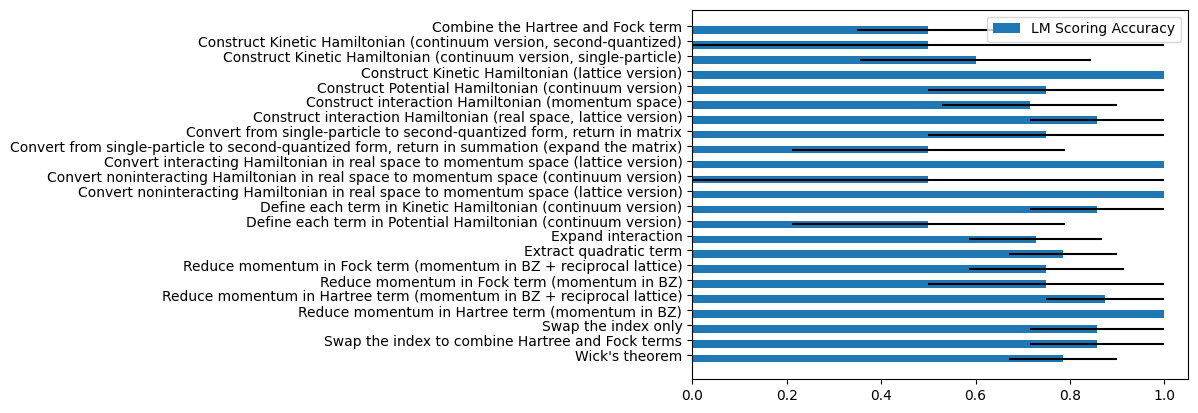

In [ ]:
import matplotlib.pyplot as plt
width = 0.5

Ntasks = mask_single_tasks.sum()
fig, ax = plt.subplots()
ax.barh(np.arange(Ntasks), mean_tasks_pl, xerr=sem_tasks_pl, height=width, label = 'LM Scoring Accuracy')
ax.set_yticks(np.arange(Ntasks)-width*0.5, task_names)
ax.legend()
ax.invert_yaxis()
plt.savefig(os.path.join(ZS_DIR, 'scoring_accuracy.png'))
plt.show()

In [ ]:
result = execution_df.groupby(['task'], as_index=True).agg({'binary_scoring_accuracy':['mean','sem'], 'task': ['count']})

In [ ]:
result

binary_scoring_accuracy  \
                                                                      mean   
task                                                                         
Combine the Hartree and Fock term                                 0.500000   
Construct Kinetic Hamiltonian (continuum versio...                0.500000   
Construct Kinetic Hamiltonian (continuum versio...                0.600000   
Construct Kinetic Hamiltonian (lattice version)                   1.000000   
Construct Potential Hamiltonian (continuum vers...                0.750000   
Construct interaction Hamiltonian (momentum space)                0.714286   
Construct interaction Hamiltonian (real space, ...                0.857143   
Convert from single-particle to second-quantize...                0.750000   
Convert from single-particle to second-quantize...                0.500000   
Convert interacting Hamiltonian in real space t...                1.000000   
Convert noninteracting Hamiltonian in real spac...                0.500000   
Convert noninteracting Hamiltonian in real spac...                1.000000   
Define each term in Kinetic Hamiltonian (contin...                0.857143   
Define each term in Potential Hamiltonian (cont...                0.500000   
Expand interaction                                                0.727273   
Extract quadratic term                                            0.785714   
Hartree term only                                                 1.000000   
Particle-hole transformation                                      1.000000   
Reduce momentum in Fock term (momentum in BZ + ...                0.750000   
Reduce momentum in Fock term (momentum in BZ)                     0.750000   
Reduce momentum in Hartree term (momentum in BZ...                0.875000   
Reduce momentum in Hartree term (momentum in BZ)                  1.000000   
Simplify the Hamiltonian in the particle-hole b...                1.000000   
Swap the index only                                               0.857143   
Swap the index to combine Hartree and Fock terms                  0.857143   
Wick's theorem                                                    0.785714   

                                                              task  
                                                         sem count  
task                                                                
Combine the Hartree and Fock term                   0.150756    12  
Construct Kinetic Hamiltonian (continuum versio...  0.500000     2  
Construct Kinetic Hamiltonian (continuum versio...  0.244949     5  
Construct Kinetic Hamiltonian (lattice version)     0.000000     7  
Construct Potential Hamiltonian (continuum vers...  0.250000     4  
Construct interaction Hamiltonian (momentum space)  0.184428     7  
Construct interaction Hamiltonian (real space, ...  0.142857     7  
Convert from single-particle to second-quantize...  0.250000     4  
Convert from single-particle to second-quantize...  0.288675     4  
Convert interacting Hamiltonian in real space t...  0.000000     7  
Convert noninteracting Hamiltonian in real spac...  0.500000     2  
Convert noninteracting Hamiltonian in real spac...  0.000000     7  
Define each term in Kinetic Hamiltonian (contin...  0.142857     7  
Define each term in Potential Hamiltonian (cont...  0.288675     4  
Expand interaction                                  0.140836    11  
Extract quadratic term                              0.113804    14  
Hartree term only                                        NaN     1  
Particle-hole transformation                             NaN     1  
Reduce momentum in Fock term (momentum in BZ + ...  0.163663     8  
Reduce momentum in Fock term (momentum in BZ)       0.250000     4  
Reduce momentum in Hartree term (momentum in BZ...  0.125000     8  
Reduce momentum in Hartree term (momentum in BZ)    0.000000     5  
Simplify the Hamiltonian in the particle-hole b...       NaN   

In [ ]:
mean_tasks = result['binary_scoring_accuracy']['mean'].to_numpy()
sem_tasks = result['binary_scoring_accuracy']['sem'].to_numpy()
mask_gt_5 = result['task']['count'] > 5
mean_tasks_pl = mean_tasks[mask_gt_5]
sem_tasks_pl = sem_tasks[mask_gt_5]
Ntasks = mask_gt_5.sum()
task_names = result.index[mask_gt_5]

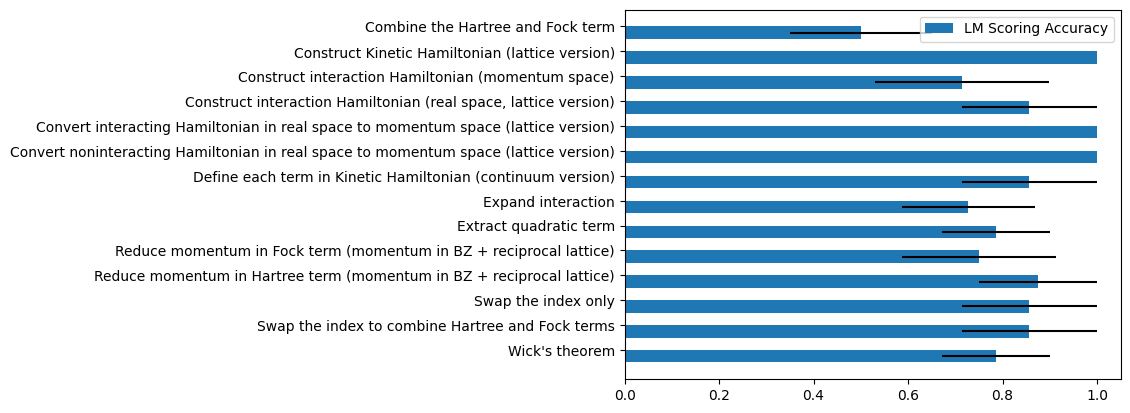

In [ ]:
import matplotlib.pyplot as plt
width = 0.5

fig, ax = plt.subplots()
ax.barh(np.arange(Ntasks), mean_tasks_pl, xerr=sem_tasks_pl, height=width, label = 'LM Scoring Accuracy')
ax.set_yticks(np.arange(Ntasks)-width*0.5, task_names)
ax.legend()
ax.invert_yaxis()
plt.savefig(os.path.join(ZS_DIR, 'scoring_accuracy_gt5.png'))
plt.show()